In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random

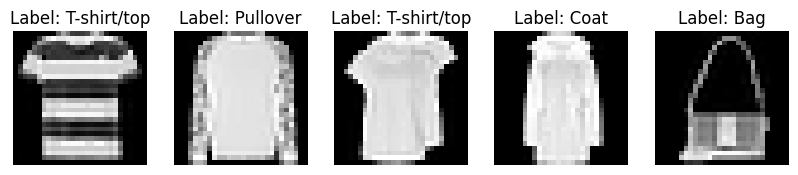

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 5
learning_rate = 0.001
num_epochs = 2
latent_dim = 32

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load FashionMNIST dataset
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
class_names = train_dataset.classes

# Visualize sample images
sample_batch, sample_labels = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_batch[i].squeeze().numpy(), cmap='gray')
    plt.title(f"Label: {class_names[sample_labels[i]]}")
    plt.axis('off')
plt.show()

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.mu = nn.Linear(32, latent_dim)
        self.log_var = nn.Linear(32, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        mu = self.mu(x)
        log_var = self.log_var(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var


# Loss function
def vae_loss_function(recon_x, x, mu, logvar, lamb=3):
    MSE = nn.functional.mse_loss(recon_x, x.view(-1, 784), reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + lamb * KLD

In [13]:
def create_mask(batch_size, images):
    mask_size = 8
    mask = torch.ones((batch_size, 1, 28, 28)).to(device)
    masked_images = images.clone()
    for i in range(batch_size):
        image_height, image_width = images.size()[2:]  # Get the height and width of the image
        top = random.randint(0, image_height - mask_size)  # Adjusted to fit within image dimensions
        left = random.randint(0, image_width - mask_size)  # Adjusted to fit within image dimensions
        # Apply the mask
        masked_images[i, :, top:top+mask_size, left:left+mask_size] = 0
    return masked_images

In [15]:
# Initialize VAE model, loss function, and optimizer
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for data in train_loader:
        images, _ = data
        images = images.to(device)

        # Forward pass
        recon_images, mu, log_var = model(images)

        # Compute the loss
        loss = vae_loss_function(recon_images, images, mu, log_var)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

print('Finished Training')

Epoch 1/2, Loss: 2542.3587
Epoch 2/2, Loss: 2488.1719
Finished Training


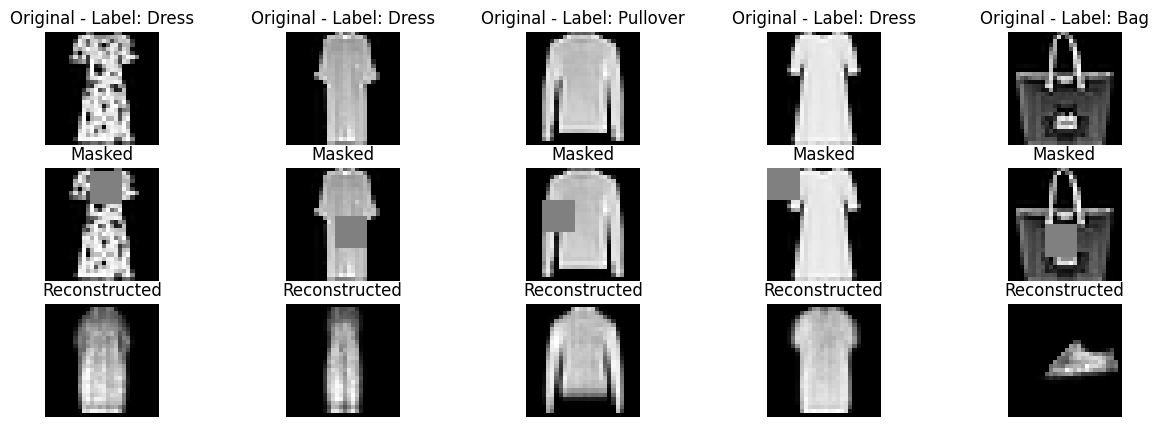

In [19]:
# Visualization
sample_batch, _ = next(iter(train_loader))

# Original Images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(sample_batch[i].squeeze().numpy(), cmap='gray')
    plt.title(f"Original - Label: {class_names[_[i]]}")
    plt.axis('off')

# Masked Images
masked_images = create_mask(batch_size, sample_batch)
for i in range(5):
    plt.subplot(3, 5, i+6)
    plt.imshow(masked_images[i].squeeze().cpu().numpy(), cmap='gray')  # Moved .cpu() here
    plt.title("Masked")
    plt.axis('off')

# Reconstructed Images
with torch.no_grad():
    sample_batch = sample_batch.to(device)
    masked_images = masked_images.to(device)
    reconstructed_images, _, _ = model(masked_images)  # Add _ to capture mu and logvar

for i in range(5):
    plt.subplot(3, 5, i+11)
    plt.imshow(reconstructed_images[i].cpu().squeeze().numpy().reshape(28, 28), cmap='gray')  # Reshape the image data
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()
